In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')


# Simple Gradient Descent Demo

Given a 2nd order polynomial h(x) = h0*x^2 + h1*x + h2, use a 3-tensor hhat and stochastic gradient descent to estimate h(x).


In [3]:
N = 20 # number of input values
x = torch.arange(0,N).float() - 20/2
#x = torch.ones((N,)).float()
print(x)


tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])


In [4]:
def f(x, h):
    """
    given 
    h : vector
    x : vector
    
    compute vector y
    where y0 = (h0 * x0^2) + (h1 * x0) + h2
    """
    #assert x.shape[0]==N
    
    #
    # vander creates a vandermonde matrix
    # specify decreasing (increasing=false) powers
    #
    # e.g.
    # [1, 2 -> vander(x, 3) ->
    #    [0,   1,    1]
    #    [0,   2,    4]
    #
    x_van = torch.vander(x, len(h), increasing=False)

    #y = torch.matmul(x_van, torch.reshape(h, (len(h), 1)))
    y = torch.matmul(x_van, h)
    return y

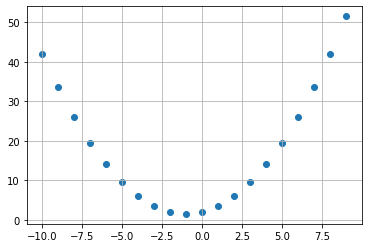

In [5]:
# make noisy observations yn
noise = torch.randn(N)*0
#h = torch.tensor([0.5, 1, 0])
h = torch.tensor([0.5, 1.0, 2.0])
#y =  0.5*(x - 9.5)**2 + 1 + noise
yn = f(x,h) + noise
plt.scatter(x, yn)
plt.grid()

In [6]:
#
# random initial vector
torch.manual_seed(0)
LEN_HHAT=3
hhat0 = torch.randn(LEN_HHAT)
#hhat0= torch.tensor([0.1,2.0,3.0])

In [7]:
#
# test in & out shapes
assert x.shape==torch.Size([N])
assert hhat0.shape==torch.Size([LEN_HHAT])

yhat=f(x, hhat0)

assert yhat.shape==torch.Size([N])

In [8]:
def show_preds(x,y,yhat, ax=None):
    """
    plot predicted vs actual 
    """
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(x, y, label='actual')
    ax.scatter(x, yhat, color='red',label='yhat')
    max_y = 1.25 * torch.max(y) 
    min_y = 1.25 * torch.min(y)
    ax.set_ylim(min_y,max_y)
    ax.grid(True)
    ax.legend()

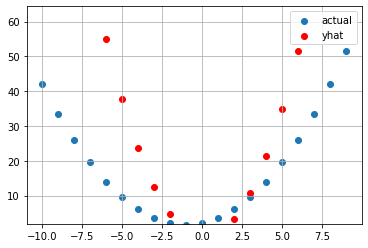

In [9]:
yhat = f(x, hhat0)
show_preds(x,yn,yhat)

In [10]:
def grad_loss(x, err):
    """
    x (N,)
    err = y-yhat (N,)
    
    grad has shape (3,)
    """
    assert err.shape==x.shape
    
    """
    x_van looks like
    [ x0^2 x1^2 x2^2 ... ]
    [ x0   x1   x2   ... ]
    [ 1    1    1    ... ]
    """
    x_van = torch.vander(x, LEN_HHAT, increasing=False)  
    x_van = x_van.T
    #print(x_van)

    #print(err)
    G = torch.zeros((LEN_HHAT,))
    
    #
    # G = gradient
    #   = (2.0/20) * x_van * err
    for n in range(LEN_HHAT):
        G[n] = torch.dot(x_van[n,:], err)
    #
    G = (-2.0/x.numel()) * G
    
    assert G.shape==torch.Size((LEN_HHAT,))
    return G
    
    


In [11]:
def loss_f(err):
    assert err.shape==torch.Size((N,))
    loss = (1.0/N) * torch.dot(err,err)
    assert loss.numel()==1  # is scalar
    return loss
    

## Single Update Step

In [12]:
#
# a single update
# split cell = ctrl shift -

hhat = torch.clone(hhat0)
print(f"hhat={hhat}")
yhat = f(x, hhat)
print(f"yhat = {yhat[0:4]}")
err = yn - yhat
print(f"err={err[0:4]}")


hhat=tensor([ 1.5410, -0.2934, -2.1788])
yhat = tensor([154.8551, 125.2828,  98.7924,  75.3840])
err=tensor([-112.8551,  -91.7828,  -72.7924,  -55.8840])


In [13]:
loss0 = loss_f(err)
print(f"loss={loss0}")

g = grad_loss(x, err)
print(f"grad={g}")

#norm_g = torch.dot(g,g.T).sqrt()
#print(f"norm_g = {norm_g}, {norm_g.numel()}")
#assert norm_g.numel()==1  # is scalar


loss=2114.721923828125
grad=tensor([4082.6790, -186.5806,   62.6826])


In [14]:
MU = 1.0e-4
update = MU * g
print(f"update={update}")
hhat = hhat0 - update
print(f"updated hhat={hhat}")
yhat = f(x, hhat)
err = yn - yhat
loss = loss_f(err)


print(f"initial loss={loss0}")
print(f"updated loss={loss}")

update=tensor([ 0.4083, -0.0187,  0.0063])
updated hhat=tensor([ 1.1327, -0.2748, -2.1851])
initial loss=2114.721923828125
updated loss=783.8820190429688


## Multiple SGD Updates

In [15]:
#
# do multiple updates
NUM_ITER=100
MU=1.0e-4
hhat = torch.clone(hhat0)
loss = torch.zeros((NUM_ITER,))
for n in range(NUM_ITER):
    yhat = f(x, hhat)
    err = yn - yhat

    loss[n] = loss_f(err)
    #print(f"iter {n}: loss={loss}")
    g = grad_loss(x, err)
    update = MU * g
    hhat = hhat - update
#


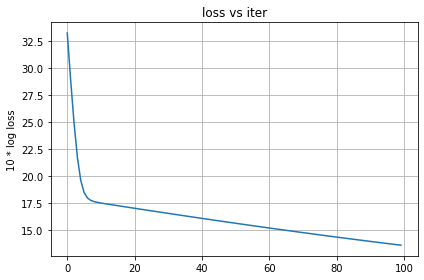

In [17]:
#
# plot loss for each iteration
fig,ax=plt.subplots(1,1)
ax.plot(10.0 * np.log10(loss))
ax.grid()
ax.set_title('loss vs iter')
ax.set_ylabel('10 * log loss')
plt.tight_layout()
plt.show()

initial hhat: tensor([ 1.5410, -0.2934, -2.1788])
final hhat: tensor([ 0.5523,  0.3559, -2.1517])


Text(0.5, 1.0, 'final estimate')

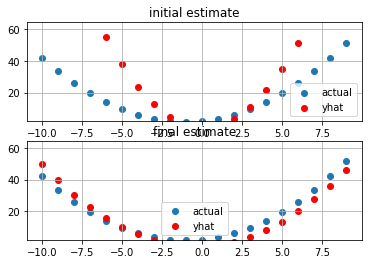

In [18]:
print(f"initial hhat: {hhat0}")
print(f"final hhat: {hhat}")
yhat0 = f(x, hhat0)
yhat = f(x, hhat)
fig,ax=plt.subplots(2,1)
show_preds(x,yn,yhat0, ax[0])
ax[0].set_title('initial estimate')
show_preds(x,yn,yhat, ax[1])
ax[1].set_title('final estimate')
